In [1]:
# %reload_ext autoreload
# %autoreload 1   
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.utils.data as data
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
# import pytorch_models
import imp
# imp.reload(pytorch_models)
# from pytorch_models import CNN_net

import matplotlib.pyplot as plt
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

EPOCHS = 100
BATCH_SIZE = 32
LEARNING_RATE = 0.01

In [46]:
TRAIN_DATA_PATH = "./lstm_data/simple/train"
TEST_DATA_PATH = "./lstm_data/simple/test"

TRANSFORM_IMG = transforms.Compose(
    [transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(), 
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

def get_loaders(bs=BATCH_SIZE):
    train_data = torchvision.datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=TRANSFORM_IMG)
    train_loader = data.DataLoader(train_data, batch_size=bs,shuffle=True, num_workers=4)
    test_data = torchvision.datasets.ImageFolder(root=TEST_DATA_PATH, transform=TRANSFORM_IMG)
    test_loader  = data.DataLoader(test_data, batch_size=bs, shuffle=True, num_workers=4)
    val_loader=test_loader
    return train_loader,test_loader,train_data,test_data,val_loader

train_loader,test_loader,train_data,test_data,val_loader = get_loaders()

classes=list(train_data.class_to_idx.keys()) #get list of classes
print(classes,len(classes))

['clap', 'hat', 'kick', 'snare', 'stacks'] 5


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


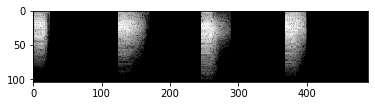

GroundTruth:  clap    clap    clap    clap


In [119]:
show_size=4
DUMMY_DATA_PATH = "./lstm_data/fake/test/clap/"
dum_t = transforms.Compose(
    [transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(), 
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

dummy_data = torchvision.datasets.ImageFolder(root=DUMMY_DATA_PATH, transform=dum_t)
dummy_loader  = data.DataLoader(dummy_data, batch_size=4, num_workers=4)

dataiter = iter(dummy_loader)
# functions to show an image
def imshow(img):
    img = img      # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
images, labels = dataiter.next()
images, labels =images[0:show_size], labels[0:show_size] 
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', '    '.join('%2s' % classes[labels[j]] for j in range(show_size)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[[ 0.7804,  0.7569,  0.7412,  ..., -1.0000, -1.0000, -1.0000],
         [ 0.6941,  0.7098,  0.6941,  ..., -1.0000, -1.0000, -1.0000],
         [ 0.7412,  0.7882,  0.7804,  ..., -1.0000, -1.0000, -1.0000],
         ...,
         [-0.0510, -0.0745, -0.1451,  ..., -1.0000, -1.0000, -1.0000],
         [-0.2314, -0.2549, -0.1529,  ..., -1.0000, -1.0000, -1.0000],
         [-0.3490, -0.3255, -0.2157,  ..., -1.0000, -1.0000, -1.0000]]])


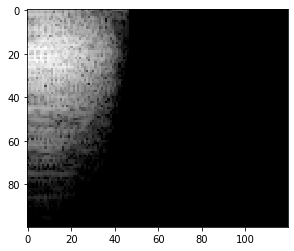

In [121]:
print(images[1])
imshow(torchvision.utils.make_grid(images[1]))

In [4]:
#io calculator
def outputSize(in_size, kernel_size, stride, padding):
    output = int((in_size - kernel_size + 2*(padding)) / stride) + 1
    print(output)
    return(output)
#get all targets


In [5]:
# let's get the weight of the samples incase we want to make a weighted
# sampler to deal with data imbalance
# # expensive to compute so commented
targets=[]
for batch_idx, (d, l) in enumerate(train_loader):
    targets.extend(list(l.numpy()))
# Compute samples weight (each sample should get its own weight)
target=torch.tensor(targets)
class_sample_count = torch.tensor(
    [(target == t).sum() for t in torch.unique(target, sorted=True)])
weight = 1. / class_sample_count.float()
samples_weight = torch.tensor([weight[t] for t in target])
print("here are the weights to account for class sizes")
print(dict(zip(classes,list(weight.numpy()*1000))))
print(weight)

here are the weights to account for class sizes
{'clap': 2.7027028, 'hat': 0.58377117, 'kick': 0.9910803, 'snare': 0.80775446, 'stacks': 0.2247191}
tensor([0.0027, 0.0006, 0.0010, 0.0008, 0.0002])


In [6]:
class LSTM1(nn.Module):
    def __init__(self, input_dim,hidden_dim, n_layers,output_size, drop_prob=0.1):
        super(LSTM1, self).__init__()
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
#         self.dropout = nn.Dropout(drop_prob)
        self.fc = nn.Linear(hidden_dim, output_size)
#         self.sigmoid = nn.Sigmoid()
        
    def forward(self, x, hidden,grad=True):
        if grad:
            x=x.view(-1, seq_dim, input_dim).requires_grad_()
        else:
            x=x.view(-1, seq_dim, input_dim)
        out, hidden = self.lstm(x, hidden)
#         lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
#         out = self.dropout(lstm_out)
        out = self.fc(out[:, -1, :])
        return out, hidden
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))
        return hidden

In [9]:
##LSTM1####
import torch.utils.data as data
batch_size=64
train_loader,test_loader,train_data,test_data,val_loader=get_loaders(bs=batch_size)
input_dim = 120
seq_dim=100
output_size = weight.size()[0]
hidden_dim = 1000
n_layers = 1


# model = LSTM1(input_dim, hidden_dim, n_layers,output_size,)

model.to(device)

criterion = nn.CrossEntropyLoss(weight=weight.to(device))
# criterion = nn.CrossEntropyLoss()

learning_rate = 0.001

optimizer = torch.optim.Adadelta(model.parameters(), lr=learning_rate)  

epochs = 40
counter = 0
print_every = 200
clip = 5
valid_loss_min = 0.35
# model.train()
# try:
#     state='./models/lstm/state_dict%d-%d-%d.pt'%(n_layers,hidden_dim,243)
#     model.load_state_dict(torch.load(state))
# except:
#     print(state,"state cannot be loaded")
for i in range(epochs):
    for inputs, labels in train_loader:
        counter += 1
        h = model.init_hidden(inputs.size()[0])
        h = tuple([e.data for e in h])
        inputs, labels = inputs.to(device), labels.to(device)
        model.zero_grad()
        output, h = model(inputs, h)
        # Get predictions from the maximum value
        _, predicted = torch.max(output.data, 1)

        loss = criterion(output, labels)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
        if counter%print_every == 0:
#             print(predicted,labels)
            val_losses = []
            model.eval()
            for inp, lab in val_loader:
                val_h = model.init_hidden(inp.size()[0])
                val_h = tuple([each.data for each in val_h])
                inp, lab = inp.to(device), lab.to(device)
                out, val_h = model(inp, val_h)
                val_loss = criterion(out.squeeze(), lab)
                val_losses.append(val_loss.item())
                
            model.train()
            print("Epoch: {}/{}...".format(i+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)))
            if np.mean(val_losses) <= valid_loss_min:
                torch.save(model.state_dict(),'./models/lstm/state_dict%d-%d-%d.pt'%(n_layers,hidden_dim,1000*np.mean(val_losses)))
                print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,np.mean(val_losses)))
                valid_loss_min = np.mean(val_losses)


Epoch: 2/20... Step: 200... Loss: 0.762102... Val Loss: 0.348022
Validation loss decreased (0.350000 --> 0.348022).  Saving model ...
Epoch: 3/20... Step: 400... Loss: 0.283778... Val Loss: 0.351449
Epoch: 5/20... Step: 600... Loss: 0.432449... Val Loss: 0.346954
Validation loss decreased (0.348022 --> 0.346954).  Saving model ...
Epoch: 6/20... Step: 800... Loss: 0.547686... Val Loss: 0.357651
Epoch: 8/20... Step: 1000... Loss: 0.294571... Val Loss: 0.360442
Epoch: 9/20... Step: 1200... Loss: 0.422055... Val Loss: 0.353146
Epoch: 11/20... Step: 1400... Loss: 0.344435... Val Loss: 0.352186
Epoch: 12/20... Step: 1600... Loss: 0.483725... Val Loss: 0.347867
Epoch: 14/20... Step: 1800... Loss: 0.341642... Val Loss: 0.347194
Epoch: 15/20... Step: 2000... Loss: 0.207514... Val Loss: 0.352450
Epoch: 16/20... Step: 2200... Loss: 0.711882... Val Loss: 0.351567
Epoch: 18/20... Step: 2400... Loss: 0.282546... Val Loss: 0.354808
Epoch: 19/20... Step: 2600... Loss: 0.326300... Val Loss: 0.345556
V

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


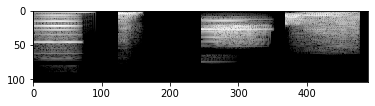

GroundTruth:  stacks         kick        stacks        stacks
Predicted:    stacks         kick        stacks        stacks


In [13]:
import torch.utils.data as data
test_size=4
testing_data = torchvision.datasets.ImageFolder(root=TEST_DATA_PATH, transform=TRANSFORM_IMG)
testing_loader  = data.DataLoader(testing_data, batch_size=test_size, shuffle=True, num_workers=4)
mod= LSTM1(input_dim, hidden_dim, n_layers,output_size)
state_path='./models/lstm/state_dict%d-%d-%d.pt'%(n_layers,hidden_dim,345)
mod.load_state_dict(torch.load(state_path))
h = mod.init_hidden(test_size)
mod.to(device)

dataiter = iter(testing_loader)
# functions to show an image
def imshow(img):
    img = img      # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', '        '.join('%5s' % classes[labels[j]] for j in range(test_size)))

inputs, labels = images.to(device), labels.to(device)
output, h = mod(inputs, h)
_, predicted = torch.max(output.data, 1)
print('Predicted:   ', '        '.join('%5s' % classes[predicted[j]]
                              for j in range(test_size)))

In [14]:
correct = 0
total = 0
with torch.no_grad():
    for d in test_loader:
        images, labels =  d[0].to(device), d[1].to(device)
        h = model.init_hidden(images.size()[0])
        outputs,h = mod(images,h)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))
class_correct = list(0. for i in range(19))
class_total = list(0. for i in range(19))

with torch.no_grad():
    for data in test_loader:
        images, labels =  data[0].to(device), data[1].to(device)
        h = model.init_hidden(images.size()[0])
        outputs,h = mod(images,h)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(BATCH_SIZE):
            try:
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
            except:
                continue

for i in range(len(classes)):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of the network on the test images: 90 %
Accuracy of  clap : 80 %
Accuracy of   hat : 79 %
Accuracy of  kick : 86 %
Accuracy of snare : 82 %
Accuracy of stacks : 98 %


(5.0, 0.0)

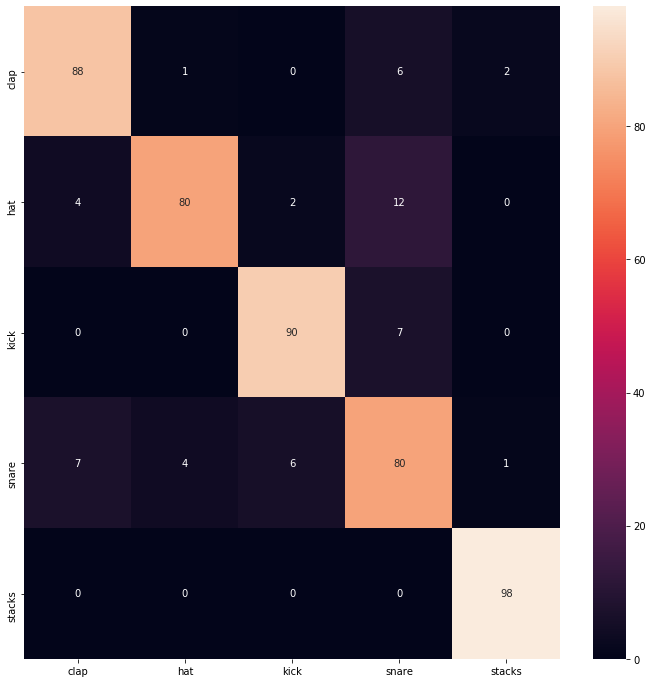

In [15]:
## making a confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

predictions=[]
l=[]
with torch.no_grad():
    for data in test_loader:
        images, labels =  data[0].to(device), data[1].to(device)
        h = mod.init_hidden(images.size()[0])
        outputs,h = mod(images,h)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())
        l.extend(labels.cpu().numpy())
cm=confusion_matrix(l,predictions)

# normalize confusion matrix per class
for i,c in enumerate(cm):
    cm[i]=c/sum(c)*100


df_cm = pd.DataFrame(cm, index = [i for i in classes],
                  columns = [i for i in classes])
plt.figure(figsize = (12,12))
sn.heatmap(df_cm, annot=True)
# fix for mpl bug that cuts off top/bottom of seaborn viz
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values